In [1]:
from custom_data import OxfordPetDataset
import custom_loader
import os
from CAM.cam_model import ResNetBackbone, CNN, fit_sgd, visualize_cam
import torch 

In [2]:
## HYPERPARAMETERS
classification_mode = "breed"
batch_size = 32

model_type = "CNN" ## CNN, Res
model_dir = os.path.join("checkpoints", "CAM")
train_mode=False # if False, will use trained local mode

num_epochs = 50

In [3]:
loss_function = torch.nn.CrossEntropyLoss()


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
minibatch_size = 32

dataset = OxfordPetDataset().prepare_dataset()
train_loader, val_loader, test_loader = custom_loader.create_dataloaders(dataset, target_type=classification_mode)

Images already downloaded: oxford_pet_data/images.tar.gz
Annotations already downloaded: oxford_pet_data/annotations.tar.gz
Dataset prepared with 35 classes.
Dataset split complete: training (70.0%), validation (15.0%), testing (15.0%)


/var/folders/4d/7160z4vd1rg28c6kn6x471p80000gn/T/ipykernel_33282/3270146577.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test.load_state_dict(torch.load(f"{mod

Using model CNN_breed
TESTING MODEL checkpoints/CAM/CNN_breed.pt


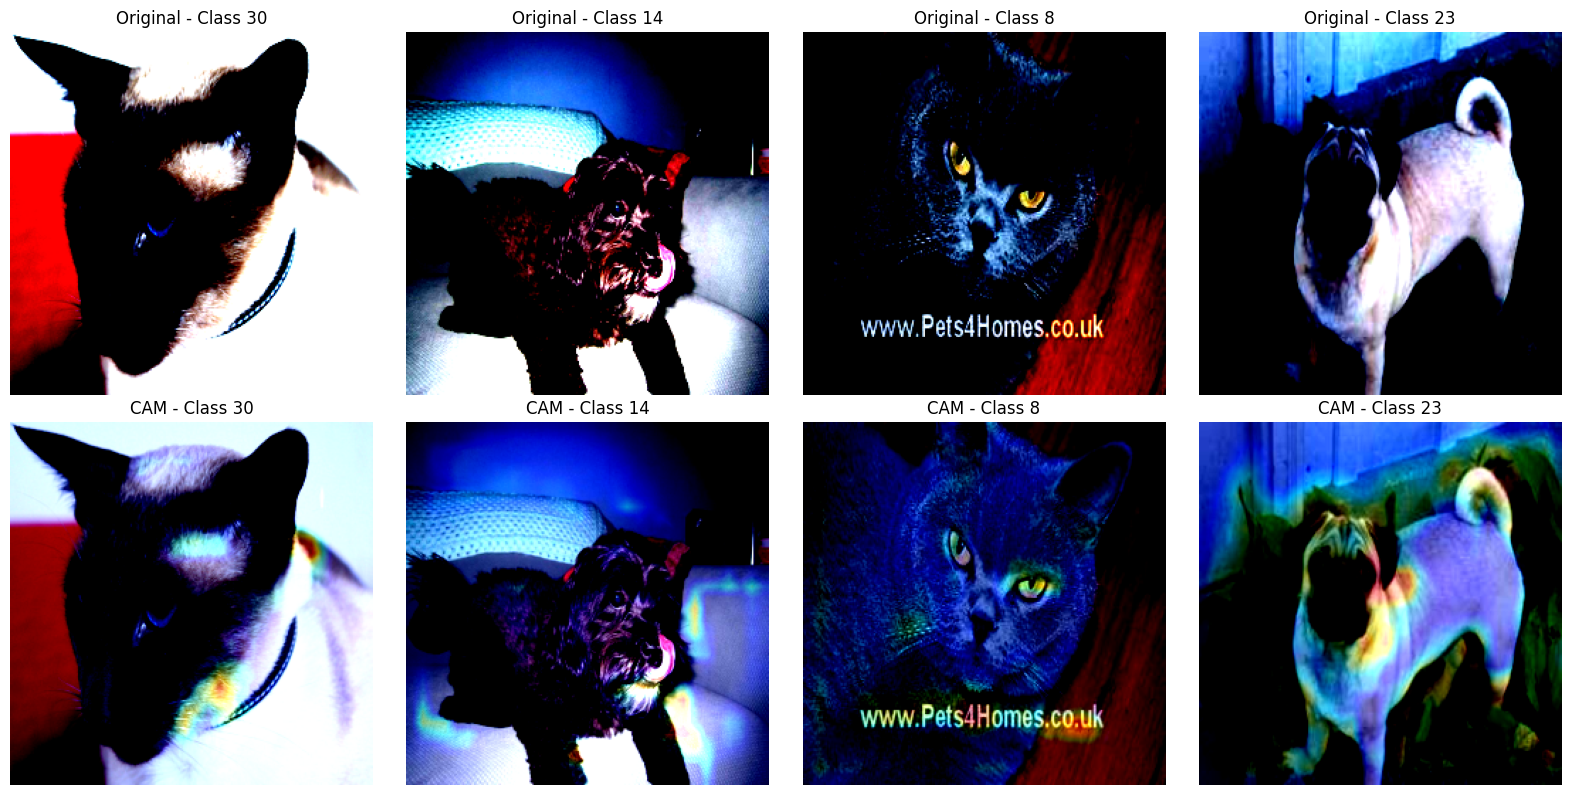

In [11]:
### MODEL INIT
model_mode = classification_mode ## species, breed
model_name = f"{model_type}_{model_mode}"
print(f"Using model {model_name}")

model_path = os.path.join(model_dir, model_name)

num_out = 37 if model_mode == "breed" else 2 

### TRAIN MODEL
if train_mode:
    model_train = ResNetBackbone(num_classes=num_out,pretrained=True) if "Res" in model_name else CNN(out_channels=256,num_classes=num_out) 
    fit_sgd(model_train, train_loader, classification_mode, num_epochs, 3e-4, model_path)

### TESTING MODEL
print(f"TESTING MODEL {model_path}.pt")
model_test = ResNetBackbone(num_classes=num_out,pretrained=False) if "Res" in model_name else CNN(out_channels=256,num_classes=num_out) 
model_test.load_state_dict(torch.load(f"{model_path}.pt"))

model_test.to(device)
model_test.eval()
visualize_cam(model_test,train_loader,model_mode, device) # Use loaded model on training dataset to show CAM
